In [1]:
# Test if SBI works
#from sbi.examples.minimal import simple
#posterior = simple()
#print(posterior)

In [2]:
import numpy as np
import torch
import MyClassesAndFcts as eva

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from torch.utils.tensorboard import SummaryWriter
from sbi.analysis import pairplot

In [3]:
def sys_def(duration=65, dt=1, t_on=1, seed=None):
    t_off = duration - t_on
    t = np.arange(0, duration + dt, dt)

    return t_on, t_off, dt, t

In [4]:
WeibSimulator = eva.CustomerBase.active_users_qrtly

def run_Weib_model(params):
    param = np.copy(params)
    param = np.asarray(param)
    #retention parameters
    par_r = np.array([param[5:9]])
    param[1:6] = param[0:5]
    param[0] = 0.0
    #acq parameters
    par_a = np.array([param[0:6]])
    # Hellofresh Datensatz - angenommene Marktgröße
    states = WeibSimulator(par_a.reshape(1, -1),par_r.reshape(1, -1), dt, t,pop=1102, q_acq=np.array([3,4]),q_ret=4,cov_mkt=cov_mkt_hf,log_alpha = True)
    return dict(data=states.reshape(-1), time=np.arange(states.size), dt=dt)

def calculate_stat_data(x,t_start = 0):
    thresh = 10  #unrealistisch viele Kunden werden gekillt, dafür diese Grenzen
    v = np.array(x["data"])
    mxy = np.max(v)
    indm = np.where(mxy==v)
    mxx = t[indm][0]
    mn = np.mean(x["data"])
    #std = np.std(x["data"])
    if mxy > thresh:
        mxy = np.nan
    
    if mxx == 0:
        mxx = np.nan
    idx = x["time"]
    idx = idx[idx < t_start]
    v[idx] = 0.0
    #Ergebnisse auf Null setzen, wenn keine Daten vorhanden sind, damit nicht falsch auf fehlende Daten gefittet wird - nicht hundertprozent sauber
    return np.concatenate((v,np.array([mxx,mxy])))

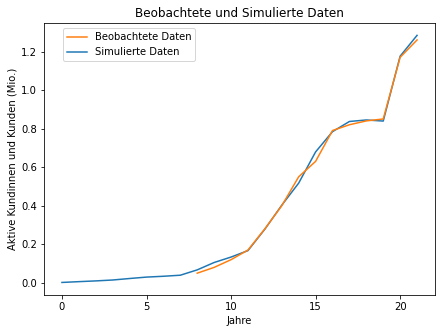

In [5]:
# Testsimulation
#p,alpha,c,r,b_q,b_m
#Hello Fresh - McCarthy Excel interpoliert für ersten Quartale

cov_mkt_hf = np.array([0.018171081,0.036342162,0.054513243,0.072684324,0.090855405,0.109026486,0.127197568,0.145368649,0.16353973,0.181710811,0.199881892,0.218052973,0.236224054,0.254395135,0.272566216,0.290737297,0.308908378,0.327079459,0.345250541,0.363421622,0.381592703,0.399763784,0.417934865,0.436105946,0.627393493,0.81868104,1.009968586,1.201256133,1.39254368,1.583831227,1.775118773,1.96640632,2.157693867,2.348981414,2.54026896,2.731556507,3.645778254,4.56,5.474221746,6.112110873,6.75,7.387889127,8.808944563,10.23,11.65105544,13.13112772,14.6112,16.09127228,14.28563614,12.48,10.67436386,11.17218193,11.67,12.16781807,12.06890904,11.97,11.87109096,11.48764548,11.1042,10.72075452,15.05037726,19.38,23.70962274,20.62981137,17.55,14.47018863]) 
t_on, t_off, dt, t = sys_def(duration=len(cov_mkt_hf)-1)
#####
#optional: Prüfe Richtigkeit von WeibSimulator und run_Weib_model
#para = np.array([[0.,14.2,1.3011,7.5,-0.1448,0.764]])
#parr = np.array([[-4.2,2.747,np.log(0.19),0.445]])
#par = np.array([14.2,1.3011,7.5,-0.1448,0.764,-4.4,2.747,np.log(0.19),0.445])
#simu = WeibSimulator(para,parr, dt, t,pop=1102, q_acq=np.array([3,4]),q_ret=4,cov_mkt=cov_mkt_hf,log_alpha=True)
#obs = run_Weib_model(par)
#plt.plot(simu)
#plt.plot(obs['time'],obs['data'], "--")
#plt.xlabel("Jahre")
#plt.ylabel("Aktive Kundinnen und Kunden (Mio.)")
#plt.title("Testsimulation")
#plt.savefig("Testsimulation")
#plt.show()
#####

true_params = np.array([np.log(1531147.),1.3011,7.5,-0.1448,0.764,np.log(0.0143),2.747,np.log(0.19),0.445])
data = np.array([0.05, 0.08, 0.12, 0.17, 0.28, 0.40, 0.55, 0.63, 0.79, 0.82, 0.84, 0.85, 1.17, 1.26])
observation_trace = run_Weib_model(true_params)
t_i = np.arange(22)
time = np.arange(data.size)+(t_i.size-data.size)
nans = np.zeros(np.min(time))
nans[:] = np.nan
observation_nan = dict(time=np.concatenate([np.arange(np.min(time)),time]),data=np.concatenate([nans,data]),dt=1)
fig = plt.figure(figsize=(7,5))
plt.plot(observation_trace['time'],observation_trace['data'], label="Simulierte Daten")
plt.plot(observation_nan['time'],observation_nan['data'], label="Beobachtete Daten")
plt.ylabel('Aktive Kundinnen und Kunden (Mio.)')
plt.title('Beobachtete und Simulierte Daten')
plt.xlabel('Jahre')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.4, 1), 
          loc='upper right')
plt.savefig("Beobachtete_Daten")
observation_summary_statistics = calculate_stat_data(observation_trace,8)

In [6]:
t_start = 8
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    obs = run_Weib_model(params)
    summstats = torch.as_tensor(calculate_stat_data(obs,t_start))
    return summstats

In [7]:
#p,alpha,c,r,b_q,b_m
labels_params = [r'$log(\alpha_{acq})$',r'$c_{acq}$',r'$r$',r'$b_{q}$',r'$b_{m}$',r'$log(\alpha_{ret})$',r'$c_{ret}$',r'$log(r)$',r'$b_{q}$']

prior_min = [5.,1.0,0.1,-.69,0.0,-6.5,0.5,-2.,-.69]
prior_max = [23.,4.5,8.1,0.69,1.0,4.6,4.5,0.,0.69]

limits = np.ones((len(prior_min),2))
for i in range(0,len(prior_min)):
    limits[i,0] = prior_min[i]
    limits[i,1] = prior_max[i]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [8]:
writer = SummaryWriter()
############################################################
num_simulations = 100000
simulator, prior = prepare_for_sbi(simulation_wrapper, prior)
inference = SNPE(prior,density_estimator="mdn",device="cpu",summary_writer=writer)

In [9]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations,num_workers=4)

Running 100000 simulations in 100000 batches.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
# train net
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator) 
fname = "WeibAcqRetCov_" + str(num_simulations)
np.savetxt(fname + "_par.txt",[labels_params,prior_min,prior_max],fmt="%s")
torch.save(density_estimator,fname + ".pt")

print(posterior)

Neural network successfully converged after 228 epochs.
Posterior conditional density p(θ|x) (amortized).

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.


In [11]:
### OR load
#fname = "WeibAcqRetCov_10000"
#loadednet = torch.load(fname + ".pt")
#inference = SNPE(prior,density_estimator="mdn",device="cpu",summary_writer=None)
#loadednet.eval()
#posterior = inference.build_posterior(loadednet)

In [12]:
samples = posterior.sample((10000,), 
                           x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/f/f_brem02/.conda/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/plot.py:181: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  "Importing `pairplot` from `sbi.utils` is deprecated since sbi "
/home/f/f_brem02/.conda/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/plot.py:198: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  "You passed an argument `fig_size`. Since sbi v0.15.0, the argument "


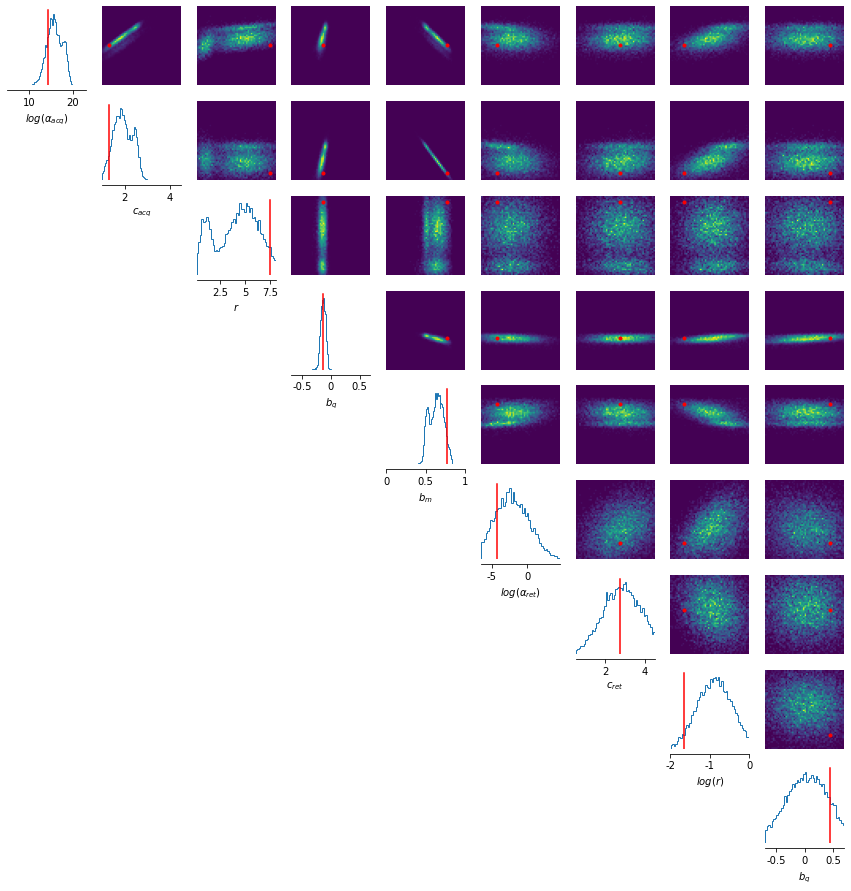

In [13]:
mean_par = np.mean(samples.squeeze().numpy(),axis=0)
fig, axes = utils.pairplot(samples,
                           limits=limits,
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(15,15),
                           points=true_params,
                           labels = labels_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');
plt.savefig(f"Parameter_{num_simulations}_simulations")

In [14]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), 
                                    x=observation_summary_statistics).numpy()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
print(posterior_sample)
true_params

[[18.592424    2.5836792   5.7712197  -0.02990951  0.47479528 -4.7667193
   2.348242   -0.73347735  0.5423011 ]]


array([14.24152769,  1.3011    ,  7.5       , -0.1448    ,  0.764     ,
       -4.24749574,  2.747     , -1.66073121,  0.445     ])

posterior mean parameters [15.722472    1.9287795   4.088031   -0.1405331   0.62865424 -2.0708132
  2.7826447  -0.8974998   0.03256819]
true parameters [14.24152769  1.3011      7.5        -0.1448      0.764      -4.24749574
  2.747      -1.66073121  0.445     ]
posterior parameters std [1.7196782  0.41207993 2.094258   0.04347812 0.08824646 2.2354398
 0.8722395  0.41173047 0.32487273]


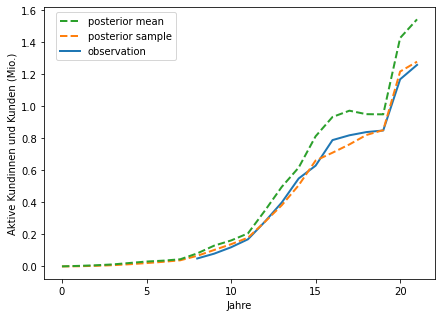

In [16]:
fig = plt.figure(figsize=(7,5))

# plot observation
t_obs = observation_nan['time']
y_obs = observation_nan['data']
plt.plot(t_obs, y_obs, lw=2, label='observation')

# simulate and plot samples
zs = run_Weib_model(posterior_sample[0])
plt.plot(t_obs, zs['data'], '--', lw=2, label='posterior sample')

zm = run_Weib_model(mean_par)
plt.plot(t_obs, zm['data'], '--', lw=2, label='posterior mean')

plt.xlabel('Jahre')
plt.ylabel('Aktive Kundinnen und Kunden (Mio.)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.35, 1), 
          loc='upper right')
plt.savefig(f"Ergebnis_{num_simulations}_simulations")

print("posterior mean parameters",mean_par)
print("true parameters",true_params)
print("posterior parameters std",np.std(samples.squeeze().numpy(),axis=0))

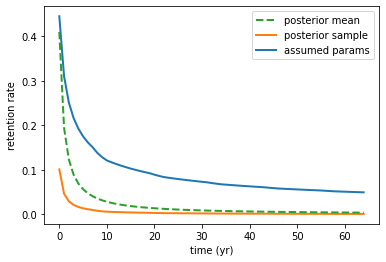

In [17]:
ret_obs = eva.CustomerBase.active_cohorts(np.array([true_params[5:9]]),dt,t,q = 4,log_alpha=True)
ret_sample = eva.CustomerBase.active_cohorts(np.array([posterior_sample[0][5:9]]),dt,t,q = 4,log_alpha=True)
ret_samples = eva.CustomerBase.active_cohorts(np.array([mean_par[5:9]]),dt,t,q = 4,log_alpha=True)
plt.plot(ret_obs[0,1:],lw=2, label='assumed params')
plt.plot(ret_sample[0,1:],lw=2, label='posterior sample')
plt.plot(ret_samples[0,1:], '--', lw=2, label='posterior mean')
plt.xlabel('time (yr)')
plt.ylabel('retention rate')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.0, 1), loc='upper right')
plt.savefig(f"Retention__{num_simulations}_simulations")